In [1]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training Data

In [3]:
import pandas as pd
from glob import glob #for finding files recursively
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import numpy as np
from PIL import Image
import time
import random

In [4]:
from facenet_pytorch import MTCNN,InceptionResnetV1
import torchvision.models as models
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [5]:
# !unzip '/content/drive/MyDrive/train-faces.zip' -d '/content/train'
!unzip '/content/drive/MyDrive/test-public-faces.zip' -d '/content/train'

Streaming output truncated to the last 5000 lines.
   creating: /content/train/__MACOSX/test-public-faces/F0020/MID8/
  inflating: /content/train/__MACOSX/test-public-faces/F0020/MID8/._P00209_face3.jpg  
  inflating: /content/train/__MACOSX/test-public-faces/F0020/._MID8  
   creating: /content/train/test-public-faces/F0020/MID9/
  inflating: /content/train/test-public-faces/F0020/MID9/P08968_face1.jpg  
   creating: /content/train/__MACOSX/test-public-faces/F0020/MID9/
  inflating: /content/train/__MACOSX/test-public-faces/F0020/MID9/._P08968_face1.jpg  
  inflating: /content/train/__MACOSX/test-public-faces/F0020/._MID9  
   creating: /content/train/test-public-faces/F0020/MID7/
  inflating: /content/train/test-public-faces/F0020/MID7/P00209_face1.jpg  
   creating: /content/train/__MACOSX/test-public-faces/F0020/MID7/
  inflating: /content/train/__MACOSX/test-public-faces/F0020/MID7/._P00209_face1.jpg  
  inflating: /content/train/__MACOSX/test-public-faces/F0020/._MID7  
   creati

In [6]:
relationshipsCSV = "/content/drive/MyDrive/test-public-relationships.csv"
train_images_folder = "/content/train/test-public-faces/"

In [7]:
# Adapted from: https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb
available_images = glob(train_images_folder + "*/*/*.jpg")

'''
Only for windows pc:
'''
print("Total Length: ", len(available_images))

for a in range(0, len(available_images)):
    available_images[a] = available_images[a].replace("\\", "/")
all_ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in available_images] #all the people

Total Length:  20726


In [42]:
#creating the training set
personPathFile = defaultdict(list)
for x in available_images:
    personPathFile[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#read from the csv to create a list of tuples
relationships = pd.read_csv(relationshipsCSV)
relationship_pairs = [(row['p1'], row['p2']) for index, row in relationships.iterrows()] # Create a list of tuples
relationship_pairs = [x for x in relationship_pairs if x[0] in all_ppl and x[1] in all_ppl] #data cleaning

# #converting into dictionary of person is related to this list of people
relationshipDict = defaultdict(list)
for item in relationship_pairs:
  relationshipDict[item[0]].append(item[1]) #you do not need to consider the item[1] because the CSV is already pretty clean

#create more data by finding the 'negative pair'
notRelationshipDict = defaultdict(list)
set_all_ppl = set(all_ppl)
#for each key(person) in the relationship dictionary, find the non-relations
count = 0
for k,v in relationshipDict.items():
    notRelationshipDict[k]=list(set_all_ppl-set(v))


# convert both dictionaries into a list of tuples with 1, 0 as labels
# for each of the image, take the first image path stored in the dictionary made earlier
# then take each of the path file in the item

trainData = []

targetRelatedCount = 36000 #32k data
relatedCount = 0
while relatedCount<targetRelatedCount:
  for k,v in relationshipDict.items():
     for relation in v:
      i2 = random.randint(0, len(personPathFile[k])-1) #random photo of person1
      i3 = random.randint(0, len(personPathFile[relation])-1) #random photo of person2
      trainData.append((personPathFile[k][i2], personPathFile[relation][i3], 1))
      relatedCount+=1
      if relatedCount>=targetRelatedCount:
          break
     if relatedCount>=targetRelatedCount:
        break


trainData = set(trainData)
trainData = list(trainData)

positiveRelationsCount = len(trainData)
print("Current Length of positive relationships: ", len(trainData))


#making non-relationships more random, with same length as trainData

# print(len(notRelationshipDict)) --> 1638 indivs


notRelationAddedCount = 0

#might choose the same relation but handled later on when convert trainData to set and back to list
while notRelationAddedCount<positiveRelationsCount:
  for k,v in notRelationshipDict.items():
     i1 = random.randint(0, len(v)-1)
     i2 = random.randint(0, len(personPathFile[k])-1) #random photo of person1
     i3 = random.randint(0, len(personPathFile[v[i1]])-1) #random photo of person2
     trainData.append((personPathFile[k][i2], personPathFile[v[i1]][i3], 0))
     notRelationAddedCount+=1
     if notRelationAddedCount>=positiveRelationsCount:
      break

print("Current Length of not relationships: ", notRelationAddedCount)
print("Current Length of total relationships: ", len(trainData))

#change trainData to set, then back to list
trainData = set(trainData)
trainData = list(trainData)
print("Current Length of total relationships: ", len(trainData))



'''

# Storing the list of tuples in a text file
with open('Cleaned_Data.txt', 'w') as file:
    for item in trainData:
        file.write(f"{item[0]}, {item[1]}, {item[2]}\n")


trainData1 = []
with open('Cleaned_Data.txt', 'r') as file:
    for l in file:
        eachTuple = l.strip().split(', ')
        trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))


'''

Current Length of positive relationships:  28210
Current Length of not relationships:  28210
Current Length of total relationships:  56420
Current Length of total relationships:  56416


'\n\n# Storing the list of tuples in a text file\nwith open(\'Cleaned_Data.txt\', \'w\') as file:\n    for item in trainData:\n        file.write(f"{item[0]}, {item[1]}, {item[2]}\n")\n\n\ntrainData1 = []\nwith open(\'Cleaned_Data.txt\', \'r\') as file:\n    for l in file:\n        eachTuple = l.strip().split(\', \')\n        trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))\n\n\n'

In [43]:
len(trainData)

56416

In [44]:
#Checking whether the trainData is created correctly
print("Total Length of all relationships: ", len(trainData))
print(trainData[:100])

Total Length of all relationships:  56416
[('/content/train/test-public-faces/F0604/MID1/P11816_face1.jpg', '/content/train/test-public-faces/F0604/MID4/P06363_face2.jpg', 1), ('/content/train/test-public-faces/F0637/MID4/P06697_face2.jpg', '/content/train/test-public-faces/F0075/MID1/P00772_face1.jpg', 0), ('/content/train/test-public-faces/F0882/MID1/P12350_face1.jpg', '/content/train/test-public-faces/F0882/MID4/P12354_face2.jpg', 1), ('/content/train/test-public-faces/F0590/MID8/P12262_face2.jpg', '/content/train/test-public-faces/F0590/MID5/P12257_face2.jpg', 1), ('/content/train/test-public-faces/F0374/MID2/P03965_face2.jpg', '/content/train/test-public-faces/F0374/MID3/P03964_face2.jpg', 1), ('/content/train/test-public-faces/F0999/MID2/P10559_face1.jpg', '/content/train/test-public-faces/F0999/MID5/P10560_face1.jpg', 1), ('/content/train/test-public-faces/F0954/MID1/P12206_face1.jpg', '/content/train/test-public-faces/F0954/MID5/P12205_face3.jpg', 1), ('/content/train/test-publ

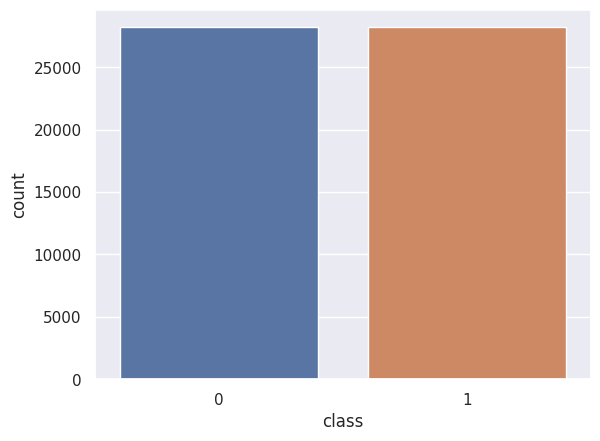

In [45]:
#checking the balance of positive and negative data
dfTrainData = pd.DataFrame (trainData, columns=['img1', 'img2', 'class'])
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [46]:
#use the pytorch built in Dataset function


class trainingDataset(Dataset):
    def __init__(self, _data, _transform=None):
        self.data = _data #choose either train or val dataset to use
        self.transform = _transform


    def __getitem__(self,index):

        first_img_path = self.data[index][0]
        second_img_path = self.data[index][1]
        img1Opened = Image.open(first_img_path)
        img2Opened = Image.open(second_img_path)


        #it is important to transform the images into tensor format
        if self.transform is not None:
            img1Opened = self.transform(img1Opened)
            img2Opened = self.transform(img2Opened)
        return img1Opened, img2Opened , self.data[index][2]

    def __len__(self):
        return len(self.data)#essential for choose the num of data in one epoch


In [47]:
BATCH_SIZE=64
IMG_SIZE=100
NUM_WORKERS = 8

# Actual transformation

'''
transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 2.0)),
transforms.ColorJitter(brightness=0.4, contrast=0.1),
transforms.RandomGrayscale(p=0.5),
transforms.RandomHorizontalFlip(),
[transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()]
'''
trainSet, valSet = train_test_split(trainData, test_size=0.1, random_state=42)
#Training set and training loader
def createTrain(transformations):
  trainset = trainingDataset(_data=trainSet,
                                          _transform=transforms.Compose(transformations))

  trainloader = DataLoader(trainset,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          batch_size=BATCH_SIZE)

  return trainloader



valset = trainingDataset(_data=valSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))


valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)





/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Define loss function and optimizer

Siamese Model

In [48]:
class SiameseNetwork(nn.Module):
    def __init__(self,mdl):

        super(SiameseNetwork, self).__init__()

        model = mdl

        for param in model.parameters():
          param.require_grad = False

        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1][:-3]))


        model.classifier = nn.Sequential(
            nn.Linear(3584,2048),
            nn.ReLU(),
            nn.Dropout(0.55),  # Add dropout for regularization
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), # Apply batch normalization
            nn.Linear(256, 2)
        )


        self.fc = model.classifier


    def forward_one(self, x):
        return self.model(x)

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)


        output = torch.cat((output1, output2),1)
        output = self.fc(output)
        return output

# model = SiameseNetwork(InceptionResnetV1(pretrained='vggface2', classify=False))


In [49]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

Finetune Model

In [50]:
# Create the Siamese network
net = SiameseNetwork(InceptionResnetV1(pretrained='vggface2', classify=False)).cuda()
# Define the contrastive loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer (e.g., Adam)
optimizer = optim.Adam(net.parameters(), lr=0.0005)


#move to gpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# model_on_gpu = model.to(device)

In [51]:
print(len(valset)) #checking the length of the validation set
print(len(trainSet)) #checking the length of test set

5642
50774


In [52]:
# Training loop
'''
transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 3.0)),
transforms.ColorJitter(brightness=0.7, contrast=0.3),
transforms.RandomGrayscale(p=0.5),
transforms.RandomHorizontalFlip(),
transforms.RandomCrop((75,75)),
[transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()]s
maybe other forms of data augmentation has to be used
apparently for some people greyscale did not work at all
image size 224
'''

BATCH_SIZE=64
NUMBER_EPOCHS=30
epoch_accuracies = np.array([])

net.train()
overall_start = time.time()
for epoch in range(1,NUMBER_EPOCHS+1):
    epoch_start = time.time()
    print("--------------------------------------------------------------------------------------------------------------", )
    total_loss = 0

    #Change Data Augmentation every other epoch
    if epoch % 10 == 0 or epoch %10 == 1 or epoch %10 == 2 or epoch %10 == 3:
      print("Data Augmentation: None")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])
    elif epoch %10 == 4 or epoch %10 == 5:
       print("Data Augmentation: RandomGrayScale(0.5)")
       trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.5),transforms.ToTensor()])
    elif epoch %10 == 6 or epoch %10 == 7:
      print("Data Augmentation: RandomCrop((90,90)),RandomGrayScale(0.8), RandomHorizontalFlip, GaussianBlur(kernel_size = 5, sigma=(0.1, 3.0)")
      trainloader = createTrain([transforms.RandomCrop((80,80)),transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.8),transforms.RandomHorizontalFlip(),transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 3.0)),transforms.ToTensor()])
    elif epoch %10 == 8 or epoch %10 == 9:
      print("Data Augmentation: RandomGrayScale(0.8), RandomHorizontalFlip, ColorJitter(brightness=0.7, contrast=0.3),")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.RandomGrayscale(p=0.5),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=0.7, contrast=0.3),transforms.ToTensor()])
    else:
      print("Data Augmentation: None")
      trainloader = createTrain([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])

    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
        optimizer.zero_grad()
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_end = time.time()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)
    print(f"Epoch {epoch}/{NUMBER_EPOCHS}, Loss: {total_loss/len(trainloader)}, Accuracy: {accuracy}, Total Time: {(epoch_end-epoch_start)/60} min")


overall_end = time.time()
best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch+1, ' WITH ACCURACY: ', best_accuracy, ' TOTAL TIME: ', (overall_end-overall_start)/60, 'min')


--------------------------------------------------------------------------------------------------------------
Data Augmentation: None
Epoch 1/30, Loss: 0.6409691739592804, Accuracy: 66.21765331442751, Total Time: 3.8901524464289348 min
--------------------------------------------------------------------------------------------------------------
Data Augmentation: None
Epoch 2/30, Loss: 0.5940539980264995, Accuracy: 68.71676710386387, Total Time: 3.8827552874883016 min
--------------------------------------------------------------------------------------------------------------
Data Augmentation: None
Epoch 3/30, Loss: 0.5528354630512314, Accuracy: 72.01347040056717, Total Time: 3.8998600363731386 min
--------------------------------------------------------------------------------------------------------------
Data Augmentation: RandomGrayScale(0.5)
Epoch 4/30, Loss: 0.5381720846035619, Accuracy: 73.11237149946827, Total Time: 3.9739821275075276 min
------------------------------------

In [53]:
!unzip '/content/drive/MyDrive/test.zip' -d '/content/test2'

Streaming output truncated to the last 5000 lines.
  inflating: /content/test2/face04688.jpg  
  inflating: /content/test2/face03972.jpg  
  inflating: /content/test2/face02593.jpg  
  inflating: /content/test2/face00836.jpg  
  inflating: /content/test2/face05284.jpg  
  inflating: /content/test2/face03261.jpg  
  inflating: /content/test2/face00582.jpg  
  inflating: /content/test2/face02696.jpg  
  inflating: /content/test2/face05325.jpg  
  inflating: /content/test2/face04973.jpg  
  inflating: /content/test2/face02902.jpg  
  inflating: /content/test2/face06245.jpg  
  inflating: /content/test2/face00645.jpg  
  inflating: /content/test2/face03284.jpg  
  inflating: /content/test2/face00188.jpg  
  inflating: /content/test2/face05490.jpg  
  inflating: /content/test2/face01683.jpg  
  inflating: /content/test2/face05566.jpg  
  inflating: /content/test2/face03288.jpg  
  inflating: /content/test2/face00045.jpg  
  inflating: /content/test2/face06050.jpg  
  inflating: /content/tes

In [54]:
class testDataset(Dataset):

    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
        self.transform = transform

    def __getitem__(self,index):

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]

        img0 = Image.open('/content/test2/'+img0_path)
        img1 = Image.open('/content/test2/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)



testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be

import numpy as np
net.eval()
test_df = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        output = net(img0,img1)
        probabilities = torch.softmax(output, dim=1) # find the probabilities

        class_1_probabilities = probabilities[:, 1]
        predictions = np.concatenate((predictions,class_1_probabilities.cpu().numpy()),0) #change back to cpu

test_df['is_related'] = predictions
test_df.to_csv("test_Results.csv", index=False) #submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed
test_df.to_csv("/content/drive/MyDrive/test_Results_SAM_NO_MTCNN_30Epochs_BatchSize_64_new_csv_probability_new_data_new_data_augment_05Drouput.csv", index=False)

In [55]:
test_df.head(50)

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.000207
1,face05750.jpg-face00898.jpg,0.992801
2,face05820.jpg-face03938.jpg,0.997181
3,face02104.jpg-face01172.jpg,0.988764
4,face02428.jpg-face05611.jpg,0.991873
5,face01219.jpg-face00274.jpg,0.000147
6,face04262.jpg-face00555.jpg,0.993558
7,face03697.jpg-face01892.jpg,0.993934
8,face03524.jpg-face00319.jpg,0.994856
9,face03410.jpg-face05368.jpg,0.000433
